In [1]:
import yfinance as yf
import pandas as pd

# Fetch historical data for a treasury yield (let's take 10-year US Treasury yields for example)
ticker = "^TNX"  # This is for 10-year US Treasury Index on Yahoo Finance
data = yf.download(ticker, start="2010-01-01", end="2024-01-01")

# Display the first few rows of the dataset
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3.859,3.859,3.808,3.841,3.841,0
2010-01-05,3.790,3.800,3.749,3.755,3.755,0
2010-01-06,3.771,3.837,3.761,3.808,3.808,0
2010-01-07,3.845,3.859,3.800,3.822,3.822,0
2010-01-08,3.843,3.851,3.775,3.808,3.808,0


In [2]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3.859,3.859,3.808,3.841,3.841,0
2010-01-05,3.790,3.800,3.749,3.755,3.755,0
2010-01-06,3.771,3.837,3.761,3.808,3.808,0
2010-01-07,3.845,3.859,3.800,3.822,3.822,0
2010-01-08,3.843,3.851,3.775,3.808,3.808,0
...,...,...,...,...,...,...
2023-12-22,3.852,3.919,3.849,3.901,3.901,0
2023-12-26,3.908,3.908,3.882,3.886,3.886,0
2023-12-27,3.852,3.852,3.785,3.789,3.789,0


In [3]:
# Extracting the 'Close' column, which represents the yield
rates = data[['Close']].rename(columns={'Close': 'Rate'})

# Interpolating any missing values
rates['Rate'] = rates['Rate'].interpolate()

# Converting the rate into a decimal (as it's often represented in percentage terms)
rates['Rate'] = rates['Rate'] / 100

# Display the cleaned data
rates.head()


,Rate
Date,
2010-01-04,0.03841
2010-01-05,0.03755
2010-01-06,0.03808
2010-01-07,0.03822
2010-01-08,0.03808


In [4]:
rates

,Rate
Date,
2010-01-04,0.03841
2010-01-05,0.03755
2010-01-06,0.03808
2010-01-07,0.03822
2010-01-08,0.03808
...,...
2023-12-22,0.03901
2023-12-26,0.03886
2023-12-27,0.03789


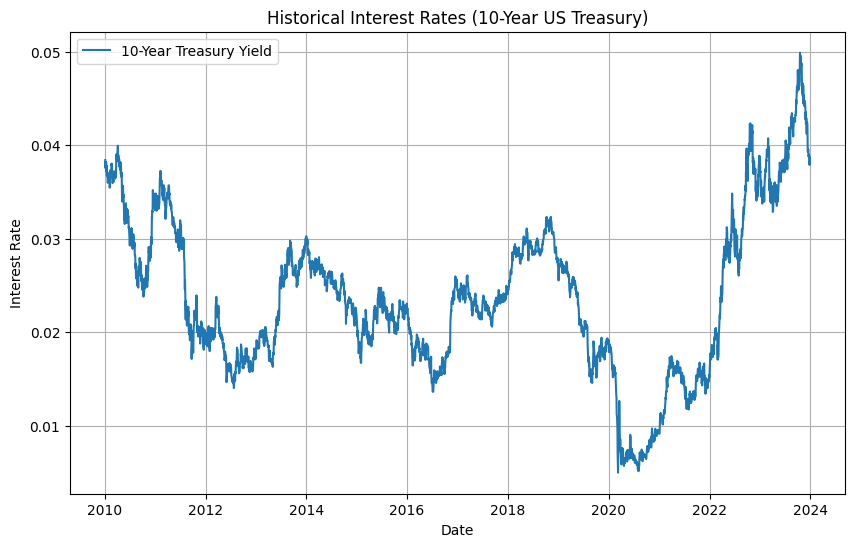

In [5]:
import matplotlib.pyplot as plt

# Plotting the historical interest rate
plt.figure(figsize=(10,6))
plt.plot(rates.index, rates['Rate'], label="10-Year Treasury Yield")
plt.title("Historical Interest Rates (10-Year US Treasury)")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.grid(True)
plt.show()


 ## Model Calibration (Hull-White Model)

Estimate Mean reversion rate ($\alpha$) and volatility($\sigma$)

In [6]:
import numpy as np
from scipy.optimize import minimize

# Define the log-likelihood function for the Hull-White model
def hull_white_log_likelihood(params, rates):
    alpha, sigma = params
    log_likelihood = 0.0
    
    # Calculate daily returns (differences in rates)
    dt = 1  # Assuming daily data (for dt in years)
    rate_diff = np.diff(rates['Rate'])
    
    # Estimate the long-term mean (theta)
    theta = np.mean(rates['Rate'])
    
    for i in range(1, len(rates)):
        # The expected rate change based on Hull-White model
        expected_rate = alpha * (theta - rates['Rate'][i - 1]) * dt
        
        # Log-likelihood contribution for each time step
        variance = sigma**2 * dt
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - (rate_diff[i-1] - expected_rate)**2 / (2 * variance)
    
    return -log_likelihood  # We minimize the negative log-likelihood


In [7]:
# Initial guesses for alpha and sigma
initial_params = [0.1, 0.01]

# Minimize the negative log-likelihood to find optimal alpha and sigma
result = minimize(hull_white_log_likelihood, initial_params, args=(rates,))
alpha, sigma = result.x

# Output the calibrated parameters
print(f"Calibrated mean reversion rate (alpha): {alpha}")
print(f"Calibrated volatility (sigma): {sigma}")


C:\Users\user\AppData\Local\Temp\ipykernel_39712\462955994.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_rate = alpha * (theta - rates['Rate'][i - 1]) * dt
C:\Users\user\AppData\Local\Temp\ipykernel_39712\462955994.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_rate = alpha * (theta - rates['Rate'][i - 1]) * dt


Calibrated mean reversion rate (alpha): 0.002029152755512375
Calibrated volatility (sigma): 0.0005365186339637108


In [8]:
alpha

0.002029152755512375

Simulating Interest Rate Scenarios Using the Hull-White Model

Use the Euler-Maruyama method to discretize the SDE.
Simulate multiple paths to analyze possible future interest rate movements.

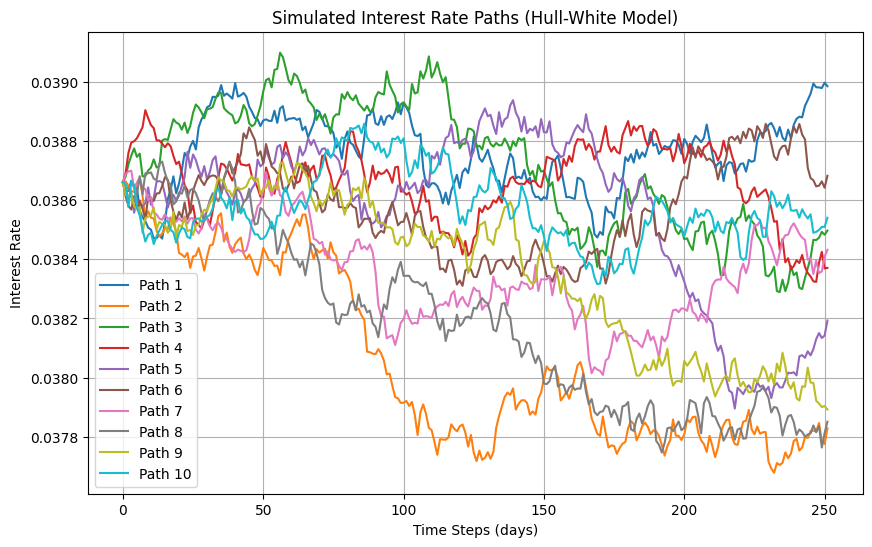

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_simulations = 10  # Number of interest rate paths to simulate
n_steps = 252  # Number of time steps (assuming 252 trading days in a year)
dt = 1 / 252  # Time step size (1 day in years)
r0 = rates['Rate'].iloc[-1]  # Starting rate as the last observed rate

# Calibrated parameters from the previous step
alpha, sigma
theta = np.mean(rates['Rate'])  # Long-term mean

# Initialize the array to store simulations
simulated_rates = np.zeros((n_simulations, n_steps))
simulated_rates[:, 0] = r0

# Simulate the interest rate paths
for i in range(n_simulations):
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Random shock (Wiener process)
        dr = alpha * (theta - simulated_rates[i, t - 1]) * dt + sigma * dW
        simulated_rates[i, t] = simulated_rates[i, t - 1] + dr

# Plot the simulated interest rate paths
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(simulated_rates[i], label=f'Path {i+1}')
plt.title('Simulated Interest Rate Paths (Hull-White Model)')
plt.xlabel('Time Steps (days)')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.legend()
plt.show()


Each line represents a possible future trajectory for the short-term interest rate over 252 days (approximately one year). 

### Key Takeaways:
- Volatility: You can see that while the rates fluctuate, they remain within a relatively narrow band, reflecting the model's volatility parameter (
𝜎
σ) which was quite low (0.00054). This suggests relatively stable rates with some degree of uncertainty.

- Mean Reversion: Some of the paths that initially deviate from the mean (either upwards or downwards) appear to revert towards the average rate over time. This demonstrates the mean reversion effect (controlled by 
𝛼
α) in the Hull-White model, where rates are pulled towards a long-term average.

- Divergence of Paths: While all paths start from the same initial interest rate (the final observed rate in your historical data), they quickly diverge due to the stochastic nature of the model. Some rates increase over time, while others decrease, capturing the possible range of future interest rate scenarios.

###  Pricing Caps and Floor

In [10]:
# Pricing parameters
notional = 1000000  # Notional amount (e.g., $1 million)
cap_rate = 0.039  # Cap rate (e.g., 3.9%)
floor_rate = 0.0375  # Floor rate (e.g., 3.75%)
discount_rate = 0.02  # Assume a constant discount rate for simplicity (2%)

# Initialize arrays to store cap and floor payoffs
cap_payoffs = np.zeros(n_steps)
floor_payoffs = np.zeros(n_steps)

# Iterate through each time step and compute the payoff for each path
for t in range(1, n_steps):
    # Discount factor for time t
    discount_factor = np.exp(-discount_rate * t * dt)
    
    # Calculate the cap and floor payoffs for each path
    for i in range(n_simulations):
        cap_payoff = notional * max(simulated_rates[i, t] - cap_rate, 0) * discount_factor
        floor_payoff = notional * max(floor_rate - simulated_rates[i, t], 0) * discount_factor
        
        # Sum the discounted payoffs across all simulations
        cap_payoffs[t] += cap_payoff / n_simulations
        floor_payoffs[t] += floor_payoff / n_simulations

# Sum the payoffs across all time steps
total_cap_value = np.sum(cap_payoffs)
total_floor_value = np.sum(floor_payoffs)

# Output the results
print(f"Total Cap Value: {total_cap_value:.2f}")
print(f"Total Floor Value: {total_floor_value:.2f}")


Total Cap Value: 75.55
Total Floor Value: 0.00


## Scenerio Analysis

 ### Scenario Analysis — Higher Volatility

In [11]:
# Scenario 1: Higher Volatility
sigma_high = sigma * 2  # Double the volatility

# Re-run the simulation with higher volatility
simulated_rates_high_vol = np.zeros((n_simulations, n_steps))
simulated_rates_high_vol[:, 0] = r0

for i in range(n_simulations):
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = alpha * (theta - simulated_rates_high_vol[i, t - 1]) * dt + sigma_high * dW
        simulated_rates_high_vol[i, t] = simulated_rates_high_vol[i, t - 1] + dr

# Recalculate the payoffs with higher volatility
cap_payoffs_high_vol = np.zeros(n_steps)
floor_payoffs_high_vol = np.zeros(n_steps)

for t in range(1, n_steps):
    discount_factor = np.exp(-discount_rate * t * dt)
    for i in range(n_simulations):
        cap_payoff = notional * max(simulated_rates_high_vol[i, t] - cap_rate, 0) * discount_factor
        floor_payoff = notional * max(floor_rate - simulated_rates_high_vol[i, t], 0) * discount_factor
        
        cap_payoffs_high_vol[t] += cap_payoff / n_simulations
        floor_payoffs_high_vol[t] += floor_payoff / n_simulations

# Calculate total value
total_cap_value_high_vol = np.sum(cap_payoffs_high_vol)
total_floor_value_high_vol = np.sum(floor_payoffs_high_vol)

print(f"Total Cap Value with Higher Volatility: {total_cap_value_high_vol:.2f}")
print(f"Total Floor Value with Higher Volatility: {total_floor_value_high_vol:.2f}")


Total Cap Value with Higher Volatility: 36170.15
Total Floor Value with Higher Volatility: 3350.94


### Scenario Analysis — Lower Mean-Reversion Rate

In [12]:
# Scenario 2: Lower Mean Reversion Rate
alpha_low = alpha / 2  # Halve the mean reversion rate

# Re-run the simulation with lower mean reversion rate
simulated_rates_low_alpha = np.zeros((n_simulations, n_steps))
simulated_rates_low_alpha[:, 0] = r0

for i in range(n_simulations):
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = alpha_low * (theta - simulated_rates_low_alpha[i, t - 1]) * dt + sigma * dW
        simulated_rates_low_alpha[i, t] = simulated_rates_low_alpha[i, t - 1] + dr

# Recalculate the payoffs with lower mean reversion rate
cap_payoffs_low_alpha = np.zeros(n_steps)
floor_payoffs_low_alpha = np.zeros(n_steps)

for t in range(1, n_steps):
    discount_factor = np.exp(-discount_rate * t * dt)
    for i in range(n_simulations):
        cap_payoff = notional * max(simulated_rates_low_alpha[i, t] - cap_rate, 0) * discount_factor
        floor_payoff = notional * max(floor_rate - simulated_rates_low_alpha[i, t], 0) * discount_factor
        
        cap_payoffs_low_alpha[t] += cap_payoff / n_simulations
        floor_payoffs_low_alpha[t] += floor_payoff / n_simulations

# Calculate total value
total_cap_value_low_alpha = np.sum(cap_payoffs_low_alpha)
total_floor_value_low_alpha = np.sum(floor_payoffs_low_alpha)

print(f"Total Cap Value with Lower Mean Reversion: {total_cap_value_low_alpha:.2f}")
print(f"Total Floor Value with Lower Mean Reversion: {total_floor_value_low_alpha:.2f}")


Total Cap Value with Lower Mean Reversion: 16396.49
Total Floor Value with Lower Mean Reversion: 0.00


GIF creation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Reuse your existing simulation parameters
n_simulations = 10
n_steps = 252
dt = 1 / 252
r0 = rates['Rate'].iloc[-1]

# Calibrated parameters
alpha = 0.002029152755512375
sigma = 0.0005365186339637108
theta = np.mean(rates['Rate'])

# Simulate the interest rate paths
simulated_rates = np.zeros((n_simulations, n_steps))
simulated_rates[:, 0] = r0

for i in range(n_simulations):
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = alpha * (theta - simulated_rates[i, t - 1]) * dt + sigma * dW
        simulated_rates[i, t] = simulated_rates[i, t - 1] + dr

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, n_steps)
ax.set_ylim(np.min(simulated_rates) * 0.99, np.max(simulated_rates) * 1.01)
ax.set_title("Simulated Interest Rate Paths (Hull-White Model)")
ax.set_xlabel("Time Steps (days)")
ax.set_ylabel("Interest Rate")
lines = [ax.plot([], [])[0] for _ in range(n_simulations)]

# Update function for the animation
def update(frame):
    for line, data in zip(lines, simulated_rates):
        line.set_data(np.arange(frame), data[:frame])
    return lines

# Create animation
ani = FuncAnimation(fig, update, frames=n_steps, blit=True)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=20)
ani.save("interest_rate_simulation.gif", writer=gif_writer)

plt.close(fig)  # Close the figure to avoid displaying a static plot in some environments
